# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [34]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import pathlib as pl;         import os
import numpy as np;           import xarray as xr
import geopandas as gpd;
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from functools import partial
from scipy.signal import find_peaks
from scipy.sparse import coo_matrix
from shapely.geometry import Point

In [35]:

def compute_keep_idx(sample_path, min_depth, max_depth):
    """
    Return indices of nodes whose depth is between min_depth and max_depth,
    excluding fill‐values.
    """
    ds0   = xr.open_dataset(sample_path, engine="netcdf4", mask_and_scale=False)
    depth = ds0.depth.values
    fv    = ds0.depth.encoding.get("_FillValue", None)
    mask  = np.ones_like(depth, dtype=bool)
    if fv is not None:
        mask &= (depth != fv)                  # drop missing
    mask &= (depth >= min_depth)             # deeper than shore
    mask &= (depth <= max_depth)             # shallower than cutoff
    keep_idx = np.where(mask)[0]
    ds0.close()
    return keep_idx

def preprocess(ds, year, keep_idx=None):
    """
    For one year’s dataset:
    - Use the file’s own time values (decoded by xarray).
    - Keep only timestamps within the calendar year (drops spin‑up & overrun).
    """
    # Convert the decoded time coordinate to pandas DatetimeIndex
    time = pd.to_datetime(ds.time.values)
    #year = time[0].year

    # Build the calendar‐year mask
    start = pd.to_datetime(f"{year}-01-01T00:00:00")
    end   = pd.to_datetime(f"{year}-12-31T23:00:00")
    mask  = (time >= start) & (time <= end)
    ds.isel(time=mask)
    if keep_idx is not None:
        ds = ds.isel(node=keep_idx)
    
    return ds
def open_zeta_dataset(root_path, years, keep_idx,
                      chunks={"time":1000, "node":20000}):
    """
    Read each year’s CF‑ified file (no chunks at open), preprocess it,
    then chunk and concatenate along time.
    """
    ds_list = []
    for year in years:
        path = pl.Path(root_path) / str(year) / "fort.63.cf.nc"
        # 1) Open without chunks
        ds = xr.open_dataset(path,
                             engine="netcdf4",
                             mask_and_scale=False)

        # 2) Preprocess (time mask, spin‑up drop, node slice)
        ds = preprocess(ds, year, keep_idx)

        # 3) Now apply chunking on the cleaned dataset
        ds = ds.chunk(chunks)

        ds_list.append(ds)

    # 4) Concatenate all years along time
    return xr.concat(ds_list, dim="time")

def build_adjacency(global_conn, keep_idx):
    """
    Filter the global connectivity to only triangles fully inside keep_idx,
    remap to local indices, and build a CSR adjacency matrix.
    """
    # 1) select triangles whose 3 nodes are all in keep_idx
    mask_tri = np.all(np.isin(global_conn, keep_idx), axis=1)
    tri_filt = global_conn[mask_tri]

    # 2) build a map from global -> local
    local_map = {g: i for i, g in enumerate(keep_idx)}
    # 3) remap
    remap = np.vectorize(local_map.get)(tri_filt)

    # 4) assemble edges
    row = np.hstack([remap[:,0], remap[:,1],
                     remap[:,1], remap[:,2],
                     remap[:,2], remap[:,0]])
    col = np.hstack([remap[:,1], remap[:,0],
                     remap[:,2], remap[:,1],
                     remap[:,0], remap[:,2]])
    data = np.ones_like(row, dtype=int)

    N = len(keep_idx)
    return sparse.coo_matrix((data, (row, col)), shape=(N, N)).tocsr()

def compute_3h_max(ds):
    """
    Compute rolling 3‑hour max on ds.zeta, keeping only the first
    two “incomplete” hours as NaN and then slicing them off.
    """
    z = ds.zeta
    # perform a 3‑step window max, requiring all 3 points
    surge3 = z.rolling(time=3, center=False, min_periods=3).max()
    # drop the first two timestamps, which will be NaN
    return surge3.isel(time=slice(2, None))
def compute_keep_idx2(
    sample_path,
    min_depth,
    max_depth,
    bbox=None,
):
    """
    Return indices of nodes whose depth is between min_depth and max_depth,
    optionally also lying within a bounding box in x/y.

    Parameters
    ----------
    sample_path : str or Path
        Path to a CF‑ified fort.63 file.
    min_depth, max_depth : float
        Depth range (inclusive) in meters.
    bbox : tuple of floats (min_x, max_x, min_y, max_y), optional
        If given, further restrict to nodes with:
           min_x <= x <= max_x  AND  min_y <= y <= max_y.

    Returns
    -------
    keep_idx : np.ndarray of int
        Indices of the `node` dimension satisfying your criteria.
    """
    ds0 = xr.open_dataset(sample_path, engine="netcdf4", mask_and_scale=False)
    
    # 1) depth mask
    depth = ds0.depth.values
    fv    = ds0.depth.encoding.get("_FillValue", None)
    mask = np.ones_like(depth, dtype=bool)
    if fv is not None:
        mask &= (depth != fv)
    mask &= (depth >= min_depth)
    mask &= (depth <= max_depth)

    # 2) optional bbox mask
    if bbox is not None:
        min_x, max_x, min_y, max_y = bbox
        x = ds0.x.values
        y = ds0.y.values
        mask &= (x >= min_x) & (x <= max_x)
        mask &= (y >= min_y) & (y <= max_y)

    ds0.close()
    return np.where(mask)[0]

In [37]:
lat1, lat2 = 56, 74
lon1, lon2 = -168.5, -140

In [38]:
root = '/scratch/tmiesse/project/data4spatial'
YEARS = range(1982, 2025)
MIN_DEPTH = -0.010
MAX_DEPTH = 7.5
bbox = (lon1, lon2, lat1, lat2)
sample_path = f"{root}/2023/fort.63.cf.nc"
keep_idx = compute_keep_idx2(
    sample_path=sample_path,
    min_depth=MIN_DEPTH,
    max_depth=MAX_DEPTH,
    bbox=bbox
)
print(f"Keeping {len(keep_idx)}")

Keeping 292975


In [39]:
global_conn = xr.open_dataset(sample_path, engine="netcdf4")["face_node_connectivity"].values - 1
adj         = build_adjacency(global_conn, keep_idx)

In [ ]:
from dask.distributed import Client, LocalCluster
import math
n_workers   = int(os.environ.get("SLURM_NTASKS", "40"))
mem_per_cpu = os.environ.get("SLURM_MEM_PER_CPU", "50GB")

cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=1,
    processes=True,
    memory_limit=mem_per_cpu
)
client = Client(cluster)
print(client)
SPINUP_DAYS= 14
DROP_START = SPINUP_DAYS * 24

<Client: 'tcp://127.0.0.1:40095' processes=40 threads=40, memory=1.82 TiB>


2025-05-23 15:43:57,875 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:40865' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-zeta-89566789283141f761dbf82b32925eca', ('open_dataset-zeta-getitem-2f54c644d8f644898b917ed14af58a1f', 1, 0)} (stimulus_id='handle-worker-cleanup-1748029437.8753633')
2025-05-23 15:43:57,942 - distributed.nanny - WARNING - Restarting worker
2025-05-23 15:43:58,075 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35105' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-zeta-1dd3f7e7ad8c94f5735f43fc37fe832a', ('open_dataset-zeta-getitem-020eb9fed4ea495f80ee90cb54977e17', 0, 0)} (stimulus_id='handle-worker-cleanup-1748029438.0753016')
2025-05-23 15:43:58,097 - distributed.nanny - WARNING - Restarting worker
2025-05-23 15:44:08,246 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1

In [41]:
SPINUP_HRS  = 14*24
def preprocess(ds):
    # 1) decode raw time → pandas
    ds = ds.assign_coords(time=pd.to_datetime(ds.time.values))
    # 2) drop anything outside that calendar year
    year = ds.time.dt.year.values[0]
    ds = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    # 3) drop the spin‑up
    ds = ds.isel(time=slice(SPINUP_HRS, None))
    # 4) subset to shallow nodes
    ds = ds.isel(node=keep_idx)
    return ds

In [42]:
paths = [str(pl.Path(root)/str(y)/"fort.63.cf.nc") for y in YEARS]
ds_all =  xr.open_mfdataset(
            paths,
            engine="netcdf4",            # <- use h5netcdf instead of netcdf4
            mask_and_scale=True,   # ← automatically turn fill‐values into NaN
            decode_cf=True,        # ← apply CF conventions (including _FillValue)
            preprocess=preprocess,
            combine="nested",
            concat_dim="time",
            chunks={'time':24})



times  = ds_all.time.values      # length T
z = ds_all.zeta.values
z = ds_all.zeta.values.astype(float)
x_all  = ds_all.x.values                          # (n_nodes,)
y_all  = ds_all.y.values                          # (n_nodes,)
th1 = np.nanpercentile(z,  95.0, axis=0)
th2 = np.nanpercentile(z,  99.9, axis=0) 
client.close()
cluster.close()

Exception ignored in: <function CachingFileManager.__del__ at 0x7f6d81a84180>
Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: HDF error


There are 1 HDF5 objects open!

Report: open objects on 72057594037927936


2025-05-23 15:43:57,874 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40865
Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/

There are 67 HDF5 objects open!

Report: open objects on 72057594037927942


2025-05-23 15:44:15,476 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:35227 -> tcp://127.0.0.1:34463
Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/comm/tcp.py", line 237, in read
    convert_stream_closed_error(self, e)
  File "/home/tmiesse/minif

In [10]:
client.close()
cluster.close()

In [43]:
s3 = np.maximum(
        np.maximum(z[2:   , :],  # z[t]
                   z[1:-1 , :]), # z[t-1]
        z[:-2  , :]               # z[t-2]
     )                            # shape = (T-2, N)
times_s3 = times[2:]             # align time axis
min_separation = 12   # hours
peaks = {}
for n in range(z.shape[1]):
    idx, props = find_peaks(
        s3[:, n],
        height=th2[n],
        distance=min_separation
    )
    if idx.size:
        peaks[n] = idx      # store peak‐indices (in s3)

print(f"Found peaks on {len(peaks)} nodes")
conn_da = ds_all.face_node_connectivity  # dims = (time, nele, nvertex)
# take the first time only
conn0 = conn_da.isel(time=0).values - 1  # now shape = (nele, nvertex)
_in      = np.isin(conn0, keep_idx)      # shape (nele, 3)
tri_mask = np.all(_in, axis=1)           # shape (nele,)
conn_flt = conn0[tri_mask, :]            # shape (n_flt, 3)

Found peaks on 285622 nodes


In [44]:
local_map = {g: i for i, g in enumerate(keep_idx)}
remap     = np.vectorize(local_map.get)(conn_flt)  # (n_flt, 3)

# 4) build symmetric adjacency graph
row = np.hstack([
    remap[:, 0], remap[:, 1],
    remap[:, 1], remap[:, 2],
    remap[:, 2], remap[:, 0],
])
col = np.hstack([
    remap[:, 1], remap[:, 0],
    remap[:, 2], remap[:, 1],
    remap[:, 0], remap[:, 2],
])
data = np.ones_like(row, dtype=bool)

adj = coo_matrix(
    (data, (row, col)),
    shape=(len(keep_idx), len(keep_idx))
).tocsr()

In [45]:
mask1 = s3 >= th1[None, :]
mask2 = s3 >= th2[None, :]
footprints = {}   # will map time‐index → array of length N with component labels

for t in np.where(mask2.any(axis=1))[0]:
    # nodes that pass the lower threshold at time t
    nodes_t = np.nonzero(mask1[t])[0]

    # subgraph of those nodes
    subgraph = adj[nodes_t][:, nodes_t]

    # label connected components within this subgraph
    labels, n_components = connected_components(subgraph, directed=False)

    # build a full‐length label array, with -1 for nodes below th1
    full_labels = -1 * np.ones(s3.shape[1], dtype=int)
    full_labels[nodes_t] = labels

    footprints[t] = full_labels

print(f"Extracted {len(footprints)} footprints at times: {list(footprints.keys())}")
event_idxs = sorted(footprints.keys())              # indices into s3/time
event_times = times_s3[event_idxs]                  # actual datetimes

# 2) Build feature‐matrix: for each event, a binary mask of nodes ≥ th1
X = mask1[event_idxs].astype(int)    

Extracted 1111 footprints at times: [np.int64(49), np.int64(50), np.int64(51), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(79), np.int64(80), np.int64(81), np.int64(82), np.int64(83), np.int64(84), np.int64(92), np.int64(93), np.int64(94), np.int64(95), np.int64(96), np.int64(97), np.int64(98), np.int64(99), np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(111), np.int64(112), np.int64(113), np.int64(142), np.int64(143), np.int64(144), np.int64(145), np.int64(146), np.int64(147), np.int64(148), np.int64(149), np.int64(150), np.int64(151), np.int64(152), np.int64(153), np.int64(154), np.int64(155), np.int64(156), np.int64(157), np.int64(158), np.int64(159), np.int64(160), np.int64(162), np.int64(163), np.int64(164), np.int64(168), np.int64(169), np.int64(170), np.int64(171), np.int64(172), np.int64(173), np.int64(174), np.int64(175), np.int64(180), np.int64(181), np.int64(182), np.int64(183), np.int64(

In [46]:
#def cluster_events(feature_matrix, n_clusters=8):
#    """PCA→KMeans clustering of your event footprints."""
#    scores = PCA(n_components=6).fit_transform(feature_matrix)
#    return KMeans(n_clusters=n_clusters, random_state=0).fit_predict(scores)
from sklearn.cluster import AgglomerativeClustering

def cluster_events(feature_matrix, n_clusters=6):
    """
    Deterministic clustering of event‐footprint PCA scores
    via agglomerative (hierarchical) clustering.
    """
    # 1) reduce dimensionality exactly as before
    scores = PCA(n_components=6).fit_transform(feature_matrix)
    # 2) do a purely deterministic clustering
    return AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage="ward"          # or "average"/"complete" — all are deterministic
    ).fit_predict(scores)

In [47]:
event_idxs = sorted(footprints.keys())    # length = 1155
n_events   = len(event_idxs)
print("n_events:", n_events)

# 2) Pull out the kept‑node coords from your concatenated dataset:
x_kept = ds_all.x.values  # shape = (n_kept,)
y_kept = ds_all.y.values  # shape = (n_kept,)

# 3) For each event t, find the single node with max s3 above th2:
x_peak = np.empty(n_events)
y_peak = np.empty(n_events)

for i, t in enumerate(event_idxs):
    row       = s3[t, :]                       # length = n_kept
    masked    = np.where(row >= th2, row, -np.inf)
    local_idx = np.argmax(masked)               # index in 0…n_kept-1
    x_peak[i] = x_kept[local_idx]
    y_peak[i] = y_kept[local_idx]

# 4) Build coords array and check shape:
coords = np.column_stack([x_peak, y_peak])     # → shape (1155, 2)?
print("coords.shape:", coords.shape)
assert coords.shape == (n_events, 2)

n_events: 1111
coords.shape: (1111, 2)


In [62]:
#n_clusters = 6
#labels = cluster_events(X, n_clusters=n_clusters)   # array length = n_events
#ds_events = xr.Dataset(
#    { "cluster": (("event",), labels) },
#    coords={
#        "event": ("event", np.arange(len(event_idxs))),
#        "time":  ("event", event_times),
#    }
#)
gdf = gpd.read_file('/scratch/tmiesse/project/counties/custom_counties.shp') \
        .to_crs("EPSG:4326") \
        .explode(index_parts=True) \
        .reset_index(drop=True)
# 2) For each polygon, get a guaranteed‑inside seed point
county_names = gdf["CommunityN"].values
seeds = np.vstack([
    geom.representative_point().coords[0]
    for geom in gdf.geometry
])  # shape = (n_counties, 2)

# 3) Build your event‑peak lon/lat arrays (one per event)
#    Make sure you’ve already computed: event_idxs, times_s3, s3, th2, x_kept, y_kept
n_events = len(event_idxs)
x_peak = np.empty(n_events);  y_peak = np.empty(n_events)
for i, t in enumerate(event_idxs):
    row       = s3[t, :]
    masked    = np.where(row >= th2, row, -np.inf)
    idx       = np.argmax(masked)
    x_peak[i] = x_kept[idx]
    y_peak[i] = y_kept[idx]

coords = np.column_stack([x_peak, y_peak])  # (n_events,2)

# 4) Run seeded K‑Means
km = KMeans(
    n_clusters=seeds.shape[0],
    init=seeds,
    n_init=1,
    algorithm="lloyd",
    random_state=0
)
labels = km.fit_predict(coords)  # length = n_events

# 5) Map each event to its county name
event_counties = county_names[labels]  # string per event

# 6) Build the ds_events Dataset
event_times = times_s3[event_idxs]
ds_events = xr.Dataset(
    {
      "cluster": (("event",), event_counties.astype(object)),
      "county_code":    (("event",), labels.astype(int)),
    },
    coords={
      "event": ("event", np.array(event_idxs, dtype=int)),
      "time":  ("event", event_times),
      "lon":   ("event", x_peak),
      "lat":   ("event", y_peak),
    }
)


In [63]:
foot_arr = np.stack([footprints[t] for t in event_idxs], axis=0)  
foot_da = xr.DataArray(
    foot_arr,
    dims=("event", "node"),
    coords={
        "event": ("event", event_idxs),
        "node":  ("node", keep_idx)
    },
    name="component"
)
ds_events = ds_events.assign(component=foot_da)
presence = (ds_events["component"] >= 0).astype(float)
avg_footprints = presence.groupby(ds_events["cluster"]).mean(dim="event")
counts = ds_events["cluster"].groupby(ds_events["cluster"]).count(dim="event")

In [64]:
ev_times = pd.to_datetime(ds_events["time"].values).tz_localize(None)
s3_times = pd.to_datetime(times_s3).tz_localize(None)

# 2) Build the list of matching indices, catching any that fail
time_idx_list = []
missing = []
for t in ev_times:
    try:
        idx = s3_times.get_loc(t)
        time_idx_list.append(int(idx))
    except KeyError:
        missing.append(t)

# 3) Report
print(f"Events in ds_events : {len(ev_times)}")
print(f"Footprints available: {len(footprints)}")
print(f"Matched indices     : {len(time_idx_list)}")
if missing:
    print("Missing event times (no s3 match):")
    for t in missing:
        print(" ", t)
else:
    print("All event times matched successfully.")

Events in ds_events : 1111
Footprints available: 1111
Matched indices     : 1111
All event times matched successfully.


In [65]:
comp_arr = np.stack([footprints[t] for t in time_idx_list], axis=0)
presence = (comp_arr >= 0).astype(int)
ecpn     = presence.sum(axis=0)

In [66]:
cluster_labels = ds_events["cluster"].values                       # strings, length = n_events
unique_labels, inv = np.unique(cluster_labels, return_inverse=True)
cluster_codes = inv                                            # ints 0…n_clusters-1
counts_per_cluster = np.bincount(cluster_codes, minlength=unique_labels.size)


In [67]:
ds_summary = xr.Dataset(
    data_vars={
        # connected‑component labels per event×node
        "component": (
            ("event","node"), comp_arr.astype(int)
        ),
        # numeric code per event
        "cluster_code": (
            ("event",), cluster_codes.astype(int)
        ),
        # how many events flooded each node
        "event_count_per_node": (
            ("node",), ecpn.astype(int)
        ),
        # how many events in each cluster
        "event_count_per_cluster": (
            ("cluster",), counts_per_cluster.astype(int)
        ),
        # string name for each cluster code
        "cluster_name": (
            ("cluster",), unique_labels.astype("U")
        ),
    },
    coords={
        "event":   ("event", ds_events["event"].values),
        "time":    ("event", ds_events["time"].values),   # only here, not in data_vars
        "node":    ("node", ds_all["node"].values),
        "x":       ("node", ds_all["x"].values),
        "y":       ("node", ds_all["y"].values),
        "cluster":("cluster", unique_labels),
    },
    attrs={
        "description":    "Surge‐event summary with cluster codes & names",
        "node_selection": f"depth {MIN_DEPTH}–{MAX_DEPTH} m",
        "spinup_hours":   SPINUP_HRS,
    }
)


# 4) Write to NetCDF
out_path = "/scratch/tmiesse/project/surge_cluster_summary.nc"
ds_summary.to_netcdf(out_path)

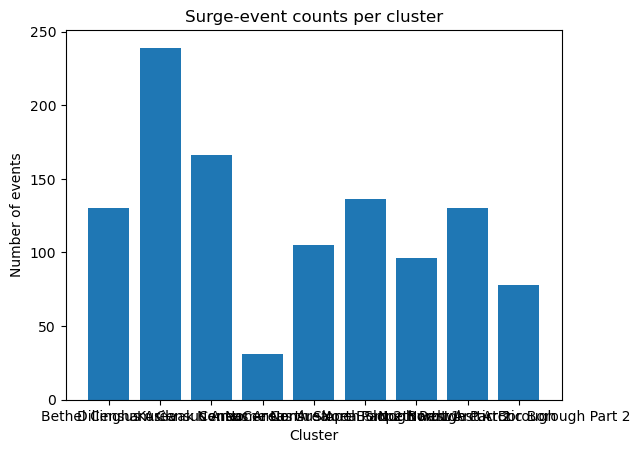

In [68]:
import matplotlib.pyplot as plt

plt.bar(counts["cluster"].values, counts.values)
plt.xlabel("Cluster")
plt.ylabel("Number of events")
plt.title("Surge‐event counts per cluster")
plt.show()

In [69]:
ds_events = ds_events.assign_coords(
    lon=("event", x_peak),
    lat=("event", y_peak)
)

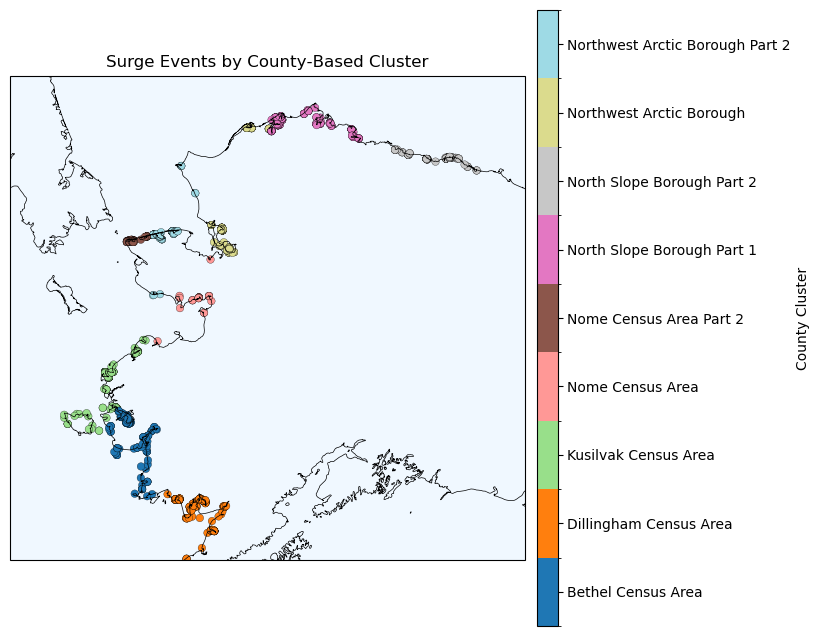

In [70]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm



lat1, lat2 = 58, 71
lon1, lon2 = -167, -140
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
use_code = True

if use_code:
    cvals = ds_events["cluster"].values
    cmap  = "tab10"
    clabel = "Cluster Code"
else:
    # if you want to map names to integers, do that:
    names = ds_events["cluster"].values  # string cluster names
    unique, inv = np.unique(names, return_inverse=True)
    cvals = inv
    cmap  = "tab20"
    clabel = "Cluster Name"

# 2) Cluster those peak‐locations
names = ds_events["cluster"].values   # e.g. ['Bristol Bay Borough', ...] length = n_events
lon   = x_peak                              # your array of peak longitudes
lat   = y_peak                              # your array of peak latitudes

# 2) Build a mapping name→integer
unique_names, inv = np.unique(names, return_inverse=True)
# unique_names  shape = (n_clusters,)
# inv           shape = (n_events,) where inv[i] is the integer code for names[i]

# 3) Prepare discrete colormap & norm
nclus = unique_names.size
cmap  = plt.get_cmap("tab20", nclus)
norm  = BoundaryNorm(boundaries=np.arange(nclus+1)-0.5, ncolors=nclus)

# 4) Make the map
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([-169, -140, 58, 71], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

# 5) Scatter using the integer codes
sc = ax.scatter(
    lon, lat,
    c=inv,
    cmap=cmap,
    norm=norm,
    s=30,
    edgecolor="k",
    linewidth=0.2,
    transform=ccrs.PlateCarree()
)

# 6) Add discrete colorbar with text labels
cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=30, ticks=np.arange(nclus))
cbar.ax.set_yticklabels(unique_names)
cbar.set_label("County Cluster")

plt.title("Surge Events by County‑Based Cluster")
plt.show()

In [ ]:
sample = pl.Path(root)/"2023"/"fort.63.cf.nc"
ds0    = xr.open_dataset(str(sample), engine="netcdf4", mask_and_scale=False)
x_all  = ds0.x.values                          # (n_nodes,)
y_all  = ds0.y.values                          # (n_nodes,)
# connectivity: drop time dim, zero‑base
conn0    = ds0.face_node_connectivity.values - 1  # now shape (nele, 3)
ds0.close()


In [25]:
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.tri as mtri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

In [32]:
#event_counts = np.zeros_like(x_all, dtype=int)
event_counts = ecpn  # shallow nodes get their counts, others stay 0
min_c, max_c = 0, 175
levels = np.arange(min_c, max_c + 2) - 0.5
n_cats = max_c - min_c + 1
cmap   = plt.get_cmap("jet", max_c - min_c + 1)
norm   = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

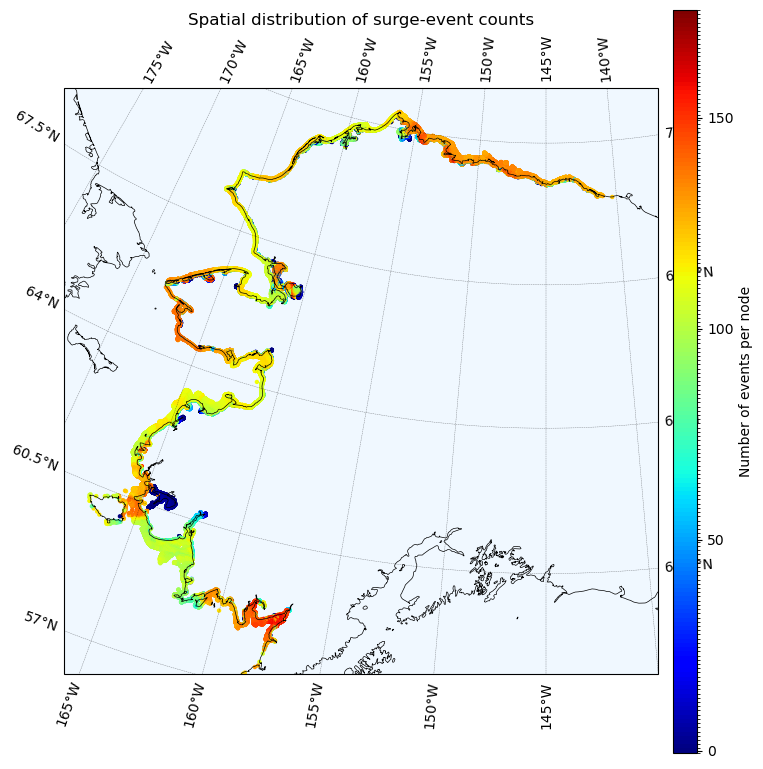

In [33]:



# 1) Triangulation (reuse your elements array)
#tri = mtri.Triangulation(x_all, y_all, triangles=conn0)

# 2) Make the map
lat1, lat2 = 58, 71
lon1, lon2 = -167, -140

fig = plt.figure(figsize=(8, 8))
ax  = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())

# base layers
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

# gridlines
gl = ax.gridlines(xlocs=np.arange(-190, -100, 5),
                  ylocs=np.arange(  50,   90, 3.5),
                  draw_labels=True, linewidth=0.3, color="black", alpha=0.5,
                  y_inline=False, linestyle="--")
gl.xlabels_top    = False
gl.ylabels_left   = False
gl.xformatter     = ccrs.cartopy.mpl.gridliner.LONGITUDE_FORMATTER

# 3) Plot the counts
sc = ax.scatter(
    x_all,
    y_all,
    c=event_counts,
    cmap=cmap,
    norm=norm,
    s=10,
    transform=ccrs.PlateCarree(),
    edgecolors="none"
)
# 4) Colorbar with integer ticks
cbar = plt.colorbar(
    sc, ax=ax,
    boundaries=levels,
    ticks=np.arange(min_c, max_c,50),
    pad=0.02,
    aspect=30
)
cbar.set_label("Number of events per node")

plt.title("Spatial distribution of surge‐event counts")
plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1) Build a pandas DataFrame for shallow‐water nodes
df = pd.DataFrame({
    "node":        keep_idx,           # global node IDs
    "x":           x_all[keep_idx],    # X coordinates
    "y":           y_all[keep_idx],    # Y coordinates
    "event_count": event_counts[keep_idx]                # events per node
})

# 2) Create Point geometries
df["geometry"] = [Point(x, y) for x, y in zip(df.x, df.y)]

# 3) Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 4) Save to a shapefile
out_path = "/scratch/tmiesse/project/event_count/event_counts.shp"
gdf.to_file(out_path)